#Хемоинформатика: QSAR и дизайн лекарств

Цель работы: познакомиться с некоторыми подходами, используемыми в хемоинформатике на примере задач фармацевтики

*   Поиск лекарств

*   Прогнозирование свойств молекул

*   Генерация новых молекул.





## 1. Знакомство с библиотекой RDKit


In [ ]:
! pip install rdkit

In [8]:
# необходимые импорты
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import sparse
from IPython.display import display,Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [5]:
from tqdm import tqdm
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Норфлоксацин является противомикробным препаратом групп ингибиторов гираз

In [ ]:
norfloxacin = Chem.MolFromSmiles("CCN1C=C(C(=O)C2=CC(=C(C=C21)N3CCNCC3)F)C(=O)O")
norfloxacin

## Дескрипторы
В работе можно расчитывать различные дескрипторы. Нпример молекулярную массу и logP

In [ ]:
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Crippen import MolLogP

print("LogP",MolLogP(norfloxacin))
print("Molecular Weight",MolWt(norfloxacin))

### Оцените возможность применения норфлоксацина в качестве лекарственного препарата.
### Правило пяти Липински:

1.   Не более 5 донорных водородных связей
2.   Не более 10 акцепторных водородных связей
3.   Молекулярная масса соединения менее 500 г/моль
4.   Коэффициент распределения октанол-вода (log P ), не должен превышать 5



In [ ]:
import rdkit.Chem.Lipinski as Lipinksy
print('NumHdonors',Lipinksy.NumHDonors(norfloxacin))
print('NumHAdonors',Lipinksy.NumHAcceptors(norfloxacin))
print('Wt',Lipinksy.rdMolDescriptors.CalcExactMolWt(norfloxacin))
print('logP',Lipinksy.rdMolDescriptors.CalcCrippenDescriptors(norfloxacin)[0])

### Фингерпринты

In [ ]:
from rdkit.Chem import rdMolDescriptors
fp_mols = rdMolDescriptors.GetMorganFingerprintAsBitVect( norfloxacin ,radius = 2)
np.array(fp_mols)

# Задание

Вам дан список [соединений](https://drive.google.com/file/d/1DlT9dxhuqWcENwS4jA70vCMQu7Nx9ORD/view?usp=drive_link).  

*   Найдите smiles (https://pubchem.ncbi.nlm.nih.gov/)
*   Постройте соединения
*   Рассчитайте дескрипторы
*   Оцените сходство найденных молекул с норфлоксацином и сделайте выводы

Принято считать, что молекулы являются схожими при значении  > 0.8


In [ ]:
alternative = ["C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O", ...  ] # Добавьте smiles в список

In [ ]:
mols = [Chem.MolFromSmiles(x) for x in alternative]

In [ ]:
# Посмотрите десприпторы и правила пяти Липински для найденных соединений
...

In [ ]:
fp_norfloxacin = AllChem.GetMorganFingerprint(norfloxacin,radius=2)
fp_mols = [AllChem.GetMorganFingerprint( x ,radius = 2) for x in mols ]

In [ ]:
sorafenib_similarity=[round(DataStructs.TanimotoSimilarity(fp_norfloxacin, x),3) for x in fp_mols]
Draw.MolsToGridImage(mols,legends = [str(x) for x in sorafenib_similarity],subImgSize=(200, 200))

Учитывая то, что каждое соединение является противомикробным лекарством широкого спектра действия, можно ли их схожесть с исходной молекулой сравнивать с активностью?

Построим карту сходства молекулы с норфлоксацином

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps

d = Draw.MolDraw2DCairo(600, 600)
somemol = mols[1] # Номер соединения в списке
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(norfloxacin, somemol, SimilarityMaps.GetMorganFingerprint,draw2d=d,size=(100, 100))
print(maxweight)
d.WriteDrawingText('similarity_map.png')
Image(filename='similarity_map.png')

### Сделайте выводы:

...

# 2. Пример применения машинного обучения для предсказания класса соединений (на примере прохождения через гематоэнцефалический барьер)

Перед нами популярный датасет о способности прохождения молекул через гематоэнцефалический барьер. Поскольку это мембрана которая блокирует множество соединений, для разработки лекартсвенных препаратов это известная проблема.

In [ ]:
data = pd.read_csv("https://uni-muenster.sciebo.de/s/Mi6YnOcTZXkKNdY/download")
data.head()

In [10]:
PandasTools.AddMoleculeColumnToFrame(frame=data, smilesCol='smiles')

,smiles,target,ROMol,set
0,CC(C)NCC(O)COc1cccc2ccccc12,1.0,,train
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1.0,,train
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1.0,,valid
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1.0,,train
4,Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)...,1.0,,train
...,...,...,...,...
1951,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1.0,,train
1952,C[S+](CCC(N)C(=O)[O-])CC1OC(n2cnc3c(N)ncnc32)C...,1.0,,train
1953,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1.0,,train
1954,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1.0,,train

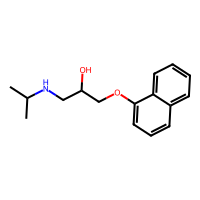
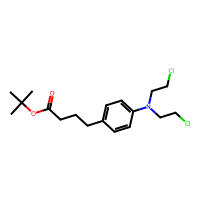
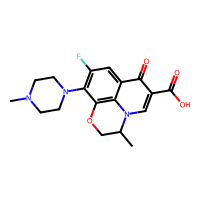
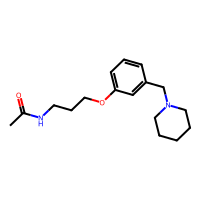
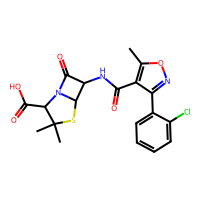
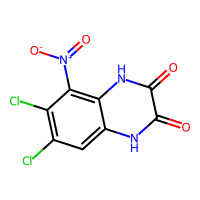
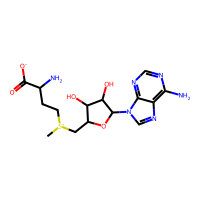
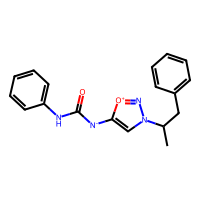
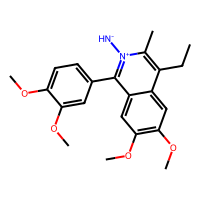
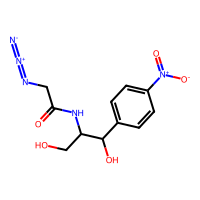

In [ ]:
train, tem = train_test_split(data, test_size=0.3, random_state=42) # разделим данные на обучающую и тестовую выборку
test, valid = train_test_split(tem, test_size=0.5, random_state=42)
data.loc[data.index.isin(train.index), 'set'] = 'train' # для удобства отобразили в данных какая молекула принадлежит к какой выборке
data.loc[data.index.isin(test.index), 'set'] = 'test'
data.loc[data.index.isin(valid.index), 'set'] = 'valid'
data

In [ ]:
def get_fingerprints(mols): # функция генерации фингерпринтов
    arr=[]
    for mol in tqdm(mols):
        arr.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,radius=2))
    return np.array(arr)

In [ ]:
X_train=get_fingerprints(data[data.set=='train'].ROMol) # вычислим фингерпринты для обучающей и тестовой выборки
X_test=get_fingerprints(data[data.set=='valid'].ROMol)

  0%|          | 0/1369 [00:00<?, ?it/s][13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRECATION WARNING: please use MorganGenerator
[13:44:47] DEPRE

Попробуем визуализировать "химическое пространство" и подобрать модель для обучения

In [ ]:
y_train=data[data.set=='train'].target.values # создали два вектора для предсказания
y_test=data[data.set=='valid'].target.values

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
decomp=pca.fit_transform(X_train)
decomp_test=pca.transform(X_test)

In [ ]:
crds_df = pd.DataFrame(decomp,columns=["PC1","PC2",'PC3'])
crds_df['is_active'] = list(y_train)
crds_df.head()

,PC1,PC2,PC3,is_active
0,-0.828610,-1.163436,-0.421650,1.0
1,-0.119218,-0.749424,-0.523085,1.0
2,-0.618337,0.507291,0.683730,1.0
3,0.051532,-0.770407,2.792466,1.0
4,-0.470619,0.565197,0.339043,1.0


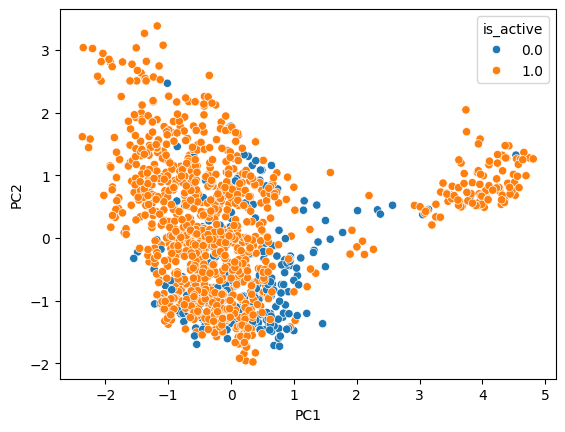

In [ ]:
ax = sns.scatterplot(data=crds_df,x="PC1",y="PC2",hue="is_active") # выберите в каком пространстве лучше происходит разделение соединений

In [ ]:
from sklearn.linear_model import RidgeClassifier # обучаем простую модель классификации с реугляризацией https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html

model=RidgeClassifier(alpha = 1.0) # гиперпараметр alpha управляет силой регуляризации
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9912344777209642

In [ ]:
pred_train=model.predict(X_train)
pred_test=model.predict(X_test)
pred_test.shape

(294,)

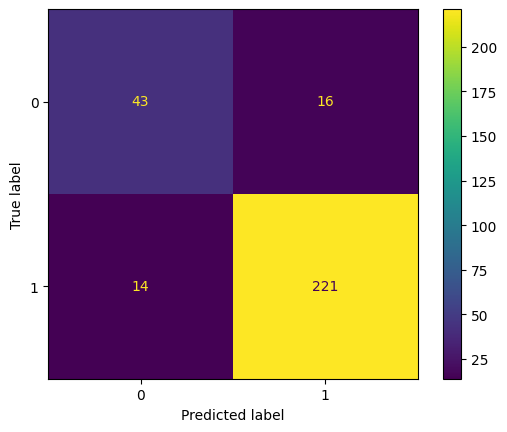

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,pred_test) # построим Confussion матрицу
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

# Задание


*   Попробуйте использовать вместо PCA [t-SNE ](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Сравните результаты
*   Подберите подходящую более сложную [модель](https://scikit-learn.org/stable/supervised_learning.html). Оцените метрики обучения.



# 3. Дизайн лекарств. Генерация новых молекул